In [4]:
import numpy as np
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import rebound
import reboundx
import time
from ctypes import cdll
from scipy.integrate import quad
from scipy.special import gamma, spence
from scipy.optimize import minimize_scalar
from numba import jit
import scipy.odr as odr
from Burkert_profile_functions import *
from NFW_profile_functions import *
from Sersic_profile_functions import *
import os
import shutil

# matplotlib setup
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['figure.facecolor'] = 'white'
plt.rc('text', usetex=True)
plt.rc('font', family='serif',size=15)
plt.rc('axes', linewidth=1.5)
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15, direction='in')
plt.rc('ytick', labelsize=15, direction='in')
plt.rc('xtick', top=True)
plt.rc('ytick', right=True)
plt.rc('xtick.minor', visible=True)
plt.rc('ytick.minor', visible=True)
plt.rc('xtick.major',size=10, pad=4)
plt.rc('xtick.minor',size=5, pad=4)
plt.rc('ytick.major',size=10)
plt.rc('ytick.minor',size=5)
plt.rc('legend', fontsize=15)

# masses of the GCs from the Georgiev catalogue in units of 1e5 solar masses
UGC7369_masses = np.array([ 0.5270876 ,  0.15333488,  1.08466861,  0.23894274,  0.53477108,
        0.66067185,  2.74824974, 43.7230426 ,  0.25702028,  0.68325756,
        0.48945594,  0.78176033,  0.98889862,  0.70596634,  1.74467125,
        1.42423357,  1.17664156,  0.49028781,  0.71836984,  0.42620355,
        0.33863009])
# total mass in GCs
UGC7369_total_mass = sum(UGC7369_masses)
# UGC 7369 effective (half-light) radius in kpc
#UGC7369_R_e = 0.90
# projected separation divided by effective radius from Georgiev
#UGC7369_rperps_norms =  np.array([2.23066667, 1.428     , 0.99866667, 1.96933333, 1.97866667,
      # 0.63466667, 0.13066667, 0.00933333, 0.24266667, 0.364     ,
       #1.372     , 0.42      , 0.644     , 0.37333333, 0.42      ,
       #0.82133333, 0.99866667, 1.77333333, 0.868     , 1.148     ,
       #1.22266667])
# physical projected radii
#UGC7369_rperps = UGC7369_rperps_norms*UGC7369_R_e

# a C implementation of friction and background forces in rebound, for speed
clib_additional_forces = cdll.LoadLibrary("/home/vk9342/USRP2023/additional_forces.so")


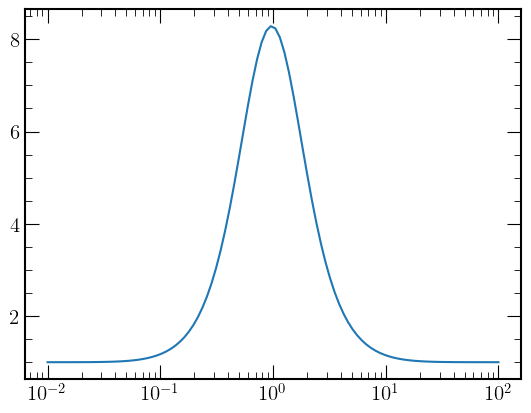

In [5]:
# mass function: gaussian in logM, mean/variance taken from Georgiev catalogue normal dist fit
def mass_function(logmass):
    # currently using a NSC cut fit
    mean = 4.987311450993631 - 5
    variance = 0.18871641457327373
    return 1/np.sqrt(2*np.pi*variance) * np.exp(-(logmass-mean)**2 / (2*variance))

# testing it out with a plot of the mass function
test_masses = np.logspace(-2, 2, 100)
plt.plot(test_masses, 10**mass_function(np.log10(test_masses)))
plt.xscale('log')
plt.show()

# custom merge function
def merge_energy(sim_pointer, collided_particles_index):
    sim = sim_pointer.contents
    ps = sim.particles
    
    i = collided_particles_index.p1
    j = collided_particles_index.p2
    
    # calculating the relevant energy to see if a merger really should happen or not
    dp = ps[i]-ps[j]
    total_mass = ps[i].m + ps[j].m
    reduced_mass = (ps[i].m*ps[j].m)/total_mass
    r_12 = np.sqrt(dp.x**2 + dp.y**2 + dp.z**2)
    v_12sq = dp.vx**2 + dp.vy**2 + dp.vz**2
    U_12 = -sim.G*ps[i].m*ps[j].m / (r_12**2.11 + (1.7*sim.softening)**2.11)**(1/2.11)
    E_12 = 0.5*reduced_mass*v_12sq + U_12
    #print('merge function called')
    if E_12 < 0:
        # if clusters did meet the energy condition, delete particle j and update particle i to the merged one
        #print(np.sqrt(ps[i].x**2 + ps[i].y**2 + ps[i].z**2), dp.vx, dp.vy, dp.vz)
        old_radius = ps[i].r
        new_particle = (ps[i]*ps[i].m + ps[j]*ps[j].m)/total_mass
        ps[i] = new_particle
        ps[i].m = total_mass
        ps[i].r = 2*2.548e-3*(total_mass/0.1)**(0.242)
        return 2
    else:
        # in case the clusters did pass near each other, but didn't meet the energy condition, do nothing
        return 0

In [6]:
# NFW ergodic distribution function, calling helpers from NFW_profile_functions.py

######################################
# MAKE SURE THESE rho_0 and r_0 ARE THE SAME AS THE ONES IN THE ADDITIONAL_FORCES FILE
######################################

rho_0_NFW = 11.82 # 10^5 solar masses / kpc^3
r_0_NFW = 19.54 # kpc
G = 0.449 # (kpc/Gyr)^2 * kpc / 10^5 solar masses
Sersic_params_NFW = [0.9, 1.18]

@np.vectorize
def NFW_ergodic_f(E):
    def integrand(psi):
        def r_psi(psi):
            rootfinding_func = lambda r: np.abs(psi + phi_NFW(r, rho_0_NFW, r_0_NFW))  #lambda (def short function) arguments : expression
            return minimize_scalar(rootfinding_func, method='bounded', bounds=[1e-20, 500]).x
        return np.sqrt(-E-psi)*d3rhodpsi3_NFW(r_psi(psi), rho_0_NFW, r_0_NFW, Sersic_params_NFW[0], Sersic_params_NFW[1])
    return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]

start = time.time()
print('Calculating NFW Energies and Weights')
energy_values_NFW = 4 * np.pi * G * rho_0_NFW * r_0_NFW**2 * np.arange(-1+0.005, -0.005, 0.005)
energy_weights_NFW = NFW_ergodic_f(energy_values_NFW)
#E_dist_NFW = [energy_values_NFW, energy_weights_NFW]
print('Finished calculating NFW Energies and Weights')
print(time.time()-start)

# Burkert ergodic distribution function, calling helpers from Burkert_profile_functions.py
rho_0_Burkert = 318.76 # 10^5 solar masses / kpc^3
r_0_Burkert = 3.36 # kpc
Sersic_params_Burkert = [0.9, 1.18]

@np.vectorize
def Burkert_ergodic_f(E):
    def integrand(psi):
        def r_psi(psi):
            rootfinding_func = lambda r: np.abs(psi + phi_Burkert(r, rho_0_Burkert, r_0_Burkert))
            return minimize_scalar(rootfinding_func, method='bounded', bounds=[1e-20, 500]).x
        return np.sqrt(-E-psi)*d3rhodpsi3_Burkert(r_psi(psi), rho_0_Burkert, r_0_Burkert, Sersic_params_Burkert[0], Sersic_params_Burkert[1])
    return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]

start = time.time()
print('Calculating Burkert Energies and Weights')
energy_values_Burkert = np.pi**2 * G * rho_0_Burkert * r_0_Burkert**2 * np.arange(-1+0.005, -0.005, 0.005)
energy_weights_Burkert = Burkert_ergodic_f(energy_values_Burkert)
#E_dist_Burkert = [energy_values_Burkert, energy_weights_Burkert]
print('Finished calculating Burkert Energies and Weights')
print(time.time()-start)

# making interpolated functions for f(E) that can be called in the initialization process for speed

#def NFW_f_interp(E):
 #   return 10**np.interp(E, energy_values_NFW, np.log10(energy_weights_NFW))

#def Burkert_f_interp(E):
 #
    #return 10**np.interp(E, energy_values_Burkert, np.log10(energy_weights_Burkert))



Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
6.725926160812378
Calculating Burkert Energies and Weights
Finished calculating Burkert Energies and Weights
7.017205715179443


In [18]:
# saves outputs for every 0.5 Gyr
R_e_values = R_e_values = np.arange(0.1, 10.1, 0.5)
n_values = [0.1, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10]
#R_e_values = [2, 10]
#n_values = [1, 3]


def NFW_f_interp(E):
    return 10**np.interp(E, energy_values_NFW, np.log10(energy_weights_NFW))

def Burkert_f_interp(E):
    return 10**np.interp(E, energy_values_Burkert, np.log10(energy_weights_Burkert))


def run_sim(potential, force, halo_params, ergodic_f, seed, t):
    
    start = time.time()
    
    np.random.seed(seed)
    
    # usual initialization of the sim, units, etc.
    sim = rebound.Simulation()
    sim.ri_ias15.epsilon = 0 # using fixed timesteps
    #sim.ri_ias15.min_dt = 1e-5
    #sim.ri_ias15.max_dt = 1e-3
    sim.dt = 5e-4 # fine to use this for quick tests, for the actual paper use the min & max above
    sim.G = 0.449 # setting units to kpc, Gyr, 10^5 M_sun
    sim.softening = 0.01 # plummer softening of 10 pc
    sim.collision = "line" # counting collisions as linear interpolations between timesteps
    sim.collision_resolve = merge_energy # conserving mass and momentum, with energy condition for mergers
    
    # Sersic radial distribution and values to draw positions with their weights
    
    pos_values = np.arange(1e-4, 10, 1e-4)
    pos_weights = nu(pos_values, R_e, n)*4*np.pi*pos_values**2
    pos_weights /= sum(pos_weights)
    
    # unpacking halo params
    rho_0 = halo_params[0]
    r_0 = halo_params[1]
    
    # setting up a mass function gaussian in logM
    logmass_values = np.linspace(-2, 2, 1000)
    logmass_weights = mass_function(logmass_values)
    logmass_weights /= sum(logmass_weights)
    
    total_GC_mass = 0
    # add particles w/ randomly drawn m, r, v until we reach the UGC7369 total GC mass
    while total_GC_mass < UGC7369_total_mass-10**(4.987311450993631 - 5):
        mass = np.exp(10/23) * 10**np.random.choice(logmass_values, p=logmass_weights) #random value is sampled from the logmass_values array with probabilities defined by the logmass_weights
        pos_rad = np.random.choice(pos_values, p=pos_weights)
        pos_theta = np.random.uniform(0, np.pi)
        pos_phi = np.random.uniform(0, 2*np.pi)
        x_i = pos_rad*np.sin(pos_theta)*np.cos(pos_phi)  #Cartesian coordinates
        y_i = pos_rad*np.sin(pos_theta)*np.sin(pos_phi)
        z_i = pos_rad*np.cos(pos_theta)

        # drawing velocities from provided distribution
        vel_values = np.arange(0.01, 100, 0.01)
        vel_weights = 4*np.pi*vel_values**2 * \
                        ergodic_f(0.5*vel_values**2 + potential(pos_rad, rho_0, r_0))/(nu(pos_rad, R_e, n))
        vel_weights /= sum(vel_weights)
        vel_mag = np.random.choice(vel_values, p=vel_weights)
        v_theta = np.random.uniform(0, np.pi)
        v_phi = np.random.uniform(0, 2*np.pi)
        vx_i = vel_mag * np.sin(v_theta)*np.cos(v_phi)
        vy_i = vel_mag * np.sin(v_theta)*np.sin(v_phi)
        vz_i = vel_mag * np.cos(v_theta)
        
        sim.add(m = mass, r = 2*2.548e-3*(mass/0.1)**(0.242), \
                x = x_i, y = y_i, z = z_i, vx = vx_i, vy = vy_i, vz = vz_i)
        total_GC_mass += mass/np.exp(10/23)
    
    rebx = reboundx.Extras(sim)
    # adding in the additional forces to work with reboundx
    myforce = rebx.create_force("additional_forces")
    myforce.force_type = "vel"
    myforce.update_accelerations = force
    rebx.add_force(myforce)
    # setting up built-in exponential mass loss
    modifymass = rebx.load_operator("modify_mass")
    rebx.add_operator(modifymass)
    # setting the mass-loss timescales of each particle, tau chosen to match linear decrease of 1/3 by end
    for p in sim.particles:
        p.params["tau_mass"] = -23
    
    # keeping track of initial positions, velocities, and masses
    initial_masses = []
    initial_positions = []
    initial_vels = []

    for p in sim.particles:
        initial_masses.append(p.m)
        initial_positions.append(np.array([p.x, p.y, p.z]))
        initial_vels.append(np.array([p.vx, p.vy, p.vz]))
    
    # integrating
    sim.integrate(t)
    
    # keeping track of final positions, velocities, and masses
    final_masses = []
    final_positions = []
    final_vels = []

    for p in sim.particles:
        final_masses.append(p.m)
        final_positions.append(np.array([p.x, p.y, p.z]))
        final_vels.append(np.array([p.vx, p.vy, p.vz]))
    
    initial_masses, final_masses = np.array(initial_masses), np.array(final_masses)
    initial_positions, final_positions = np.array(initial_positions), np.array(final_positions)
    initial_vels, final_vels = np.array(initial_vels), np.array(final_vels)
    
    # clearing sim from memory now that we've stored everything important
    sim = None
    
    # returning 3 sets of 2 things: the initial and final masses, positions, and velocities
    return [initial_masses, final_masses], [initial_positions, final_positions], [initial_vels, final_vels]

In [19]:
# run N_iterations versions of the sim, outputting every 0.5 Gyrs for 10 Gyrs

def run_iterations(N_iterations, output_name, potential, force, halo_params, ergodic_f):
    seeds = np.random.randint(1, 4294967295, size = N_iterations)
    
    start = time.time()
    
    for output_time, t in enumerate(np.arange(0, 10.5, 0.5)):
        
        if output_time == 0:
            # save initial data
            f = open('Sim_5_'+output_name+'_'+str(output_time)+'_'+str(R_e)+'_'+str(n)+'.txt', 'w')
            f.write('t = '+str(t)+' Gyr \n')
            f.write('iteration m x y z vx vy vz \n')
            for k in range(N_iterations):
                seed = seeds[k]
                masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                        halo_params = halo_params, ergodic_f = ergodic_f, \
                                                        seed = seed, t=0.001)
                for GC_n in range(len(masses[0])):
                    f.write(str(k)+' '+str(masses[0][GC_n])+' '+str(positions[0][GC_n][0])+' '\
                            +str(positions[0][GC_n][1])+' '+str(positions[0][GC_n][2])+' '\
                            +str(velocities[0][GC_n][0])+' '+str(velocities[0][GC_n][1])+' '\
                            +str(velocities[0][GC_n][2])+'\n')
            f.close()
        else:
            # save final data
            f = open('Sim_5_'+output_name+'_'+str(output_time)+'_'+str(R_e)+'_'+str(n)+'.txt', 'w')
            f.write('t = '+str(t)+' Gyr \n')
            f.write('iteration m x y z vx vy vz \n')
            for k in range(N_iterations):
                seed = seeds[k]
                masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                        halo_params = halo_params, ergodic_f = ergodic_f, \
                                                        seed = seed, t=t)
                for GC_n in range(len(masses[1])):
                    f.write(str(k)+' '+str(masses[1][GC_n])+' '+str(positions[1][GC_n][0])+' '\
                                +str(positions[1][GC_n][1])+' '+str(positions[1][GC_n][2])+' '\
                                +str(velocities[1][GC_n][0])+' '+str(velocities[1][GC_n][1])+' '\
                                +str(velocities[1][GC_n][2])+'\n')
            f.close()
            
        
        print('finished until t = '+str(t), str(time.time()-start))

finished until t = 0.0 0.30063652992248535
finished until t = 0.5 2.5622951984405518
finished until t = 1.0 6.993454456329346
finished until t = 1.5 13.752723455429077
finished until t = 2.0 22.906227350234985
finished until t = 2.5 34.5646915435791
finished until t = 3.0 48.56657123565674
finished until t = 3.5 64.81582164764404
finished until t = 4.0 83.28896307945251
finished until t = 4.5 104.0497555732727
finished until t = 5.0 127.05569553375244
finished until t = 5.5 152.16827201843262
finished until t = 6.0 179.30933141708374
finished until t = 6.5 208.37622952461243
finished until t = 7.0 239.49594616889954
finished until t = 7.5 272.5388960838318
finished until t = 8.0 307.5263454914093
finished until t = 8.5 344.3257210254669
finished until t = 9.0 382.9023859500885
finished until t = 9.5 423.3474061489105


/home/vk9342/.local/lib/python3.8/site-packages/rebound/simulation.py:1032: RuntimeWarning: At least 10 predictor corrector loops in IAS15 did not converge. This is typically an indication of the timestep being too large.
  warnings.warn(msg[1:], RuntimeWarning)


finished until t = 10.0 465.5677101612091


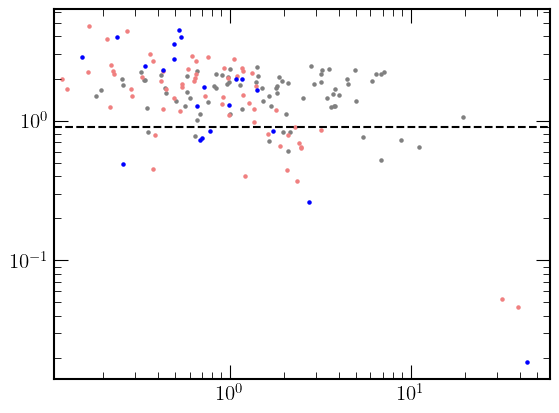

A merger has occured
finished until t = 0.0 0.2718338966369629
finished until t = 0.5 1.984166145324707
finished until t = 1.0 5.234097480773926
finished until t = 1.5 10.031178951263428
finished until t = 2.0 16.415846824645996
finished until t = 2.5 24.523865938186646
finished until t = 3.0 34.41584277153015
finished until t = 3.5 46.1917290687561
finished until t = 4.0 59.78614354133606
finished until t = 4.5 75.31079125404358
finished until t = 5.0 92.85744285583496
finished until t = 5.5 112.39700841903687
finished until t = 6.0 133.8407645225525
finished until t = 6.5 157.20386719703674
finished until t = 7.0 182.47271943092346
finished until t = 7.5 209.517995595932
finished until t = 8.0 238.21652913093567
finished until t = 8.5 268.4158034324646
finished until t = 9.0 300.07608127593994
finished until t = 9.5 333.21571016311646
finished until t = 10.0 367.83410930633545


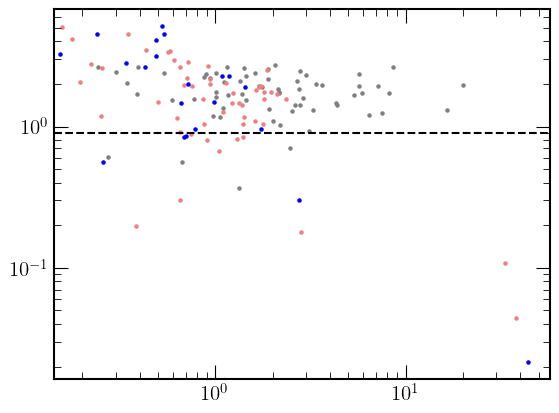

A merger has occured
finished until t = 0.0 0.2151508331298828
finished until t = 0.5 2.282482147216797
finished until t = 1.0 6.170846462249756
finished until t = 1.5 11.898135662078857
finished until t = 2.0 19.440292835235596
finished until t = 2.5 28.807749271392822
finished until t = 3.0 40.05723738670349
finished until t = 3.5 53.19792890548706
finished until t = 4.0 68.3199691772461
finished until t = 4.5 85.49859881401062
finished until t = 5.0 105.01811957359314
finished until t = 5.5 127.0057258605957
finished until t = 6.0 151.58874940872192


/home/vk9342/.local/lib/python3.8/site-packages/rebound/simulation.py:1032: RuntimeWarning: At least 10 predictor corrector loops in IAS15 did not converge. This is typically an indication of the timestep being too large.
  warnings.warn(msg[1:], RuntimeWarning)


finished until t = 6.5 178.6381537914276
finished until t = 7.0 208.02172231674194
finished until t = 7.5 239.66389179229736
finished until t = 8.0 273.77504301071167
finished until t = 8.5 310.2038595676422
finished until t = 9.0 349.06317710876465
finished until t = 9.5 390.2149887084961
finished until t = 10.0 433.6339452266693


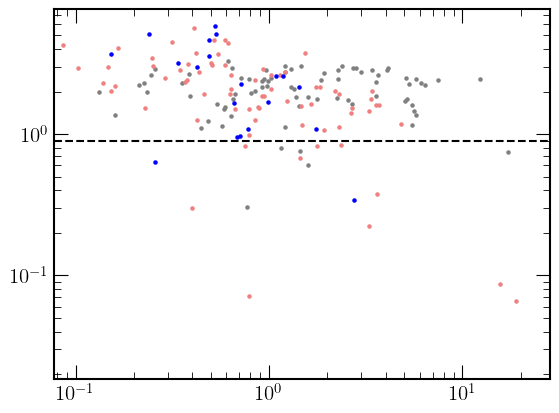

A merger has occured
finished until t = 0.0 0.18435120582580566
finished until t = 0.5 1.8851323127746582
finished until t = 1.0 5.089344024658203
finished until t = 1.5 9.820573091506958
finished until t = 2.0 16.12372636795044
finished until t = 2.5 24.21727204322815
finished until t = 3.0 34.20292830467224
finished until t = 3.5 46.23094606399536
finished until t = 4.0 60.33742356300354
finished until t = 4.5 76.42533659934998
finished until t = 5.0 94.51635885238647
finished until t = 5.5 114.62515830993652
finished until t = 6.0 136.6045265197754
finished until t = 6.5 160.30716586112976
finished until t = 7.0 185.70744013786316
finished until t = 7.5 212.82230854034424
finished until t = 8.0 241.6759796142578
finished until t = 8.5 272.31156730651855
finished until t = 9.0 304.7836344242096
finished until t = 9.5 338.9879615306854
finished until t = 10.0 375.07111859321594


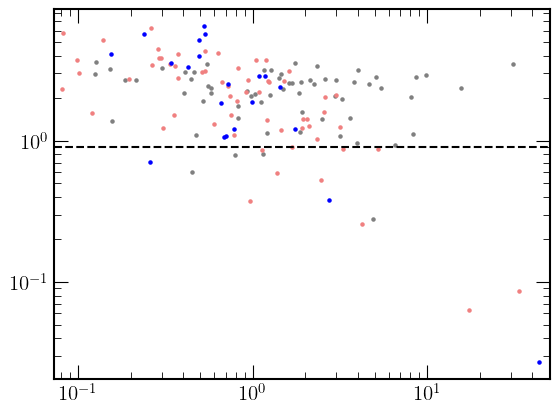

A merger has occured
finished until t = 0.0 0.194411039352417
finished until t = 0.5 1.9514858722686768
finished until t = 1.0 5.281806945800781
finished until t = 1.5 10.210897445678711
finished until t = 2.0 16.724560976028442
finished until t = 2.5 24.839736700057983
finished until t = 3.0 34.5579035282135
finished until t = 3.5 45.86034655570984
finished until t = 4.0 58.77427124977112
finished until t = 4.5 73.32317209243774
finished until t = 5.0 89.49790167808533
finished until t = 5.5 107.34437561035156
finished until t = 6.0 126.88972020149231
finished until t = 6.5 148.29560828208923
finished until t = 7.0 171.6533751487732
finished until t = 7.5 197.16851425170898
finished until t = 8.0 224.83161616325378
finished until t = 8.5 254.57601284980774
finished until t = 9.0 286.3054733276367
finished until t = 9.5 320.0691924095154
finished until t = 10.0 355.8412535190582


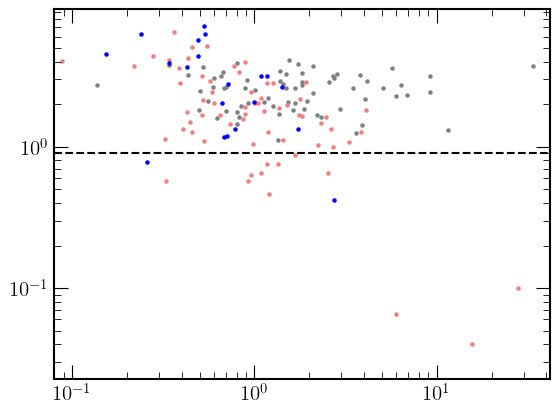

A merger has occured
finished until t = 0.0 0.24533295631408691
finished until t = 0.5 2.666654109954834
finished until t = 1.0 7.280557632446289
finished until t = 1.5 14.063079595565796
finished until t = 2.0 23.040009021759033
finished until t = 2.5 34.21084904670715
finished until t = 3.0 47.644327878952026
finished until t = 3.5 63.31341481208801
finished until t = 4.0 81.30370616912842
finished until t = 4.5 101.66937923431396
finished until t = 5.0 124.50165820121765
finished until t = 5.5 149.9891700744629
finished until t = 6.0 178.31217455863953
finished until t = 6.5 209.29171061515808
finished until t = 7.0 242.91897821426392
finished until t = 7.5 279.36312651634216
finished until t = 8.0 318.4706201553345
finished until t = 8.5 360.4117691516876
finished until t = 9.0 405.1091842651367
finished until t = 9.5 452.73966908454895
finished until t = 10.0 503.3496699333191


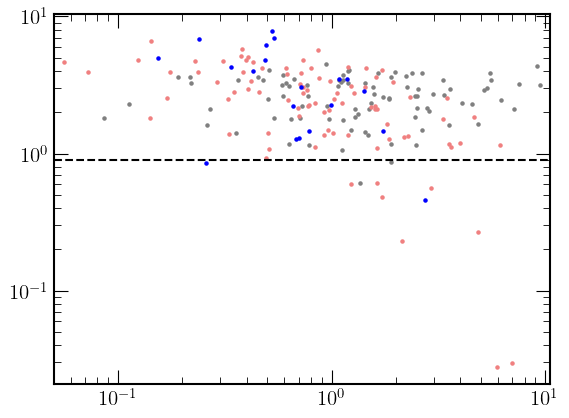

A merger has occured
finished until t = 0.0 0.21369147300720215
finished until t = 0.5 2.23183536529541
finished until t = 1.0 6.070396661758423
finished until t = 1.5 11.842701196670532
finished until t = 2.0 19.675960779190063
finished until t = 2.5 29.700473308563232
finished until t = 3.0 41.87724256515503
finished until t = 3.5 56.03065586090088
finished until t = 4.0 72.26783800125122
finished until t = 4.5 90.44361877441406
finished until t = 5.0 110.55143594741821
finished until t = 5.5 132.51896691322327
finished until t = 6.0 156.50018978118896
finished until t = 6.5 182.35070300102234
finished until t = 7.0 210.25961422920227
finished until t = 7.5 240.42330360412598
finished until t = 8.0 272.8535912036896
finished until t = 8.5 307.59658885002136
finished until t = 9.0 344.73469138145447
finished until t = 9.5 384.1154978275299
finished until t = 10.0 425.77834844589233


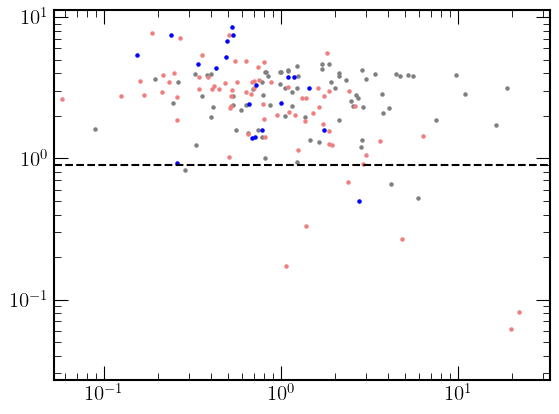

A merger has occured
finished until t = 0.0 0.18715763092041016
finished until t = 0.5 1.8578038215637207
finished until t = 1.0 5.031606435775757
finished until t = 1.5 9.69998574256897
finished until t = 2.0 15.899639368057251
finished until t = 2.5 23.707899570465088
finished until t = 3.0 33.2353298664093
finished until t = 3.5 44.52330231666565
finished until t = 4.0 57.58438444137573
finished until t = 4.5 72.50804328918457
finished until t = 5.0 89.33762264251709
finished until t = 5.5 107.98505878448486
finished until t = 6.0 128.49934697151184
finished until t = 6.5 150.88487005233765
finished until t = 7.0 175.14475417137146
finished until t = 7.5 201.31027674674988
finished until t = 8.0 229.37713241577148
finished until t = 8.5 259.40382528305054
finished until t = 9.0 291.26084637641907
finished until t = 9.5 325.0211818218231
finished until t = 10.0 360.61381578445435


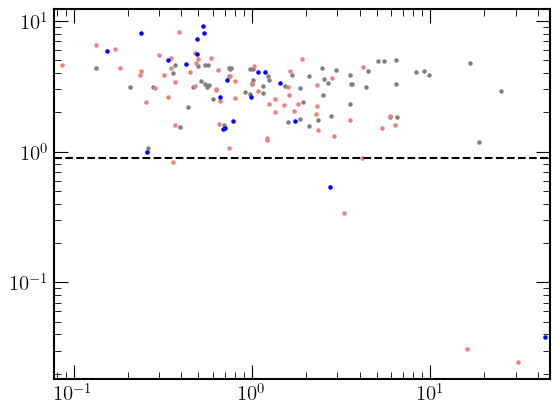

A merger has occured
finished until t = 0.0 0.22380542755126953
finished until t = 0.5 2.539402723312378
finished until t = 1.0 7.037804365158081
finished until t = 1.5 13.811725616455078
finished until t = 2.0 23.010123252868652
finished until t = 2.5 34.61032462120056
finished until t = 3.0 48.527257204055786
finished until t = 3.5 64.77831387519836
finished until t = 4.0 83.49673819541931
finished until t = 4.5 104.818430185318
finished until t = 5.0 128.96587753295898
finished until t = 5.5 155.61813640594482
finished until t = 6.0 184.79221558570862
finished until t = 6.5 216.49984741210938
finished until t = 7.0 250.77907156944275
finished until t = 7.5 287.662024974823
finished until t = 8.0 327.16443133354187
finished until t = 8.5 369.16137170791626
finished until t = 9.0 413.59114933013916
finished until t = 9.5 460.59628987312317
finished until t = 10.0 510.0800886154175


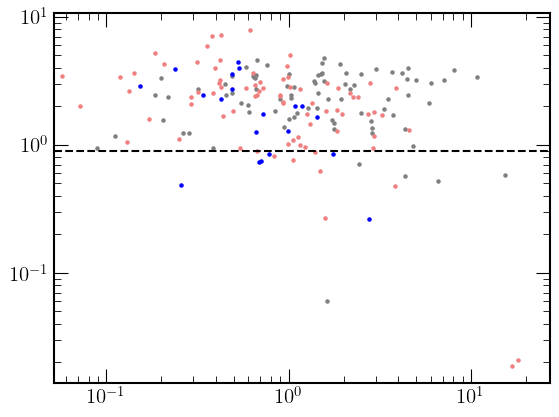

A merger has occured
finished until t = 0.0 0.22546911239624023
finished until t = 0.5 2.451746702194214
finished until t = 1.0 6.707364559173584
finished until t = 1.5 12.962760925292969
finished until t = 2.0 21.23681879043579
finished until t = 2.5 31.52469253540039
finished until t = 3.0 43.84494185447693
finished until t = 3.5 58.24449706077576
finished until t = 4.0 74.81899523735046
finished until t = 4.5 93.76786756515503
finished until t = 5.0 115.40290451049805
finished until t = 5.5 139.54262852668762
finished until t = 6.0 166.16885209083557
finished until t = 6.5 195.27370524406433
finished until t = 7.0 226.9334270954132
finished until t = 7.5 261.26247215270996
finished until t = 8.0 298.25834035873413
finished until t = 8.5 337.90769386291504
finished until t = 9.0 380.20949959754944
finished until t = 9.5 425.09300446510315
finished until t = 10.0 472.59599709510803


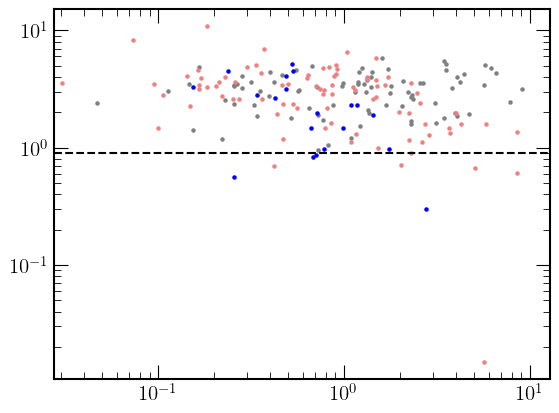

A merger has occured
finished until t = 0.0 0.26424622535705566
finished until t = 0.5 2.9719061851501465
finished until t = 1.0 8.177169799804688
finished until t = 1.5 15.857598543167114
finished until t = 2.0 26.022547245025635
finished until t = 2.5 38.65276074409485
finished until t = 3.0 53.75463795661926
finished until t = 3.5 71.30154728889465
finished until t = 4.0 91.28308749198914
finished until t = 4.5 113.71696758270264
finished until t = 5.0 138.62458300590515
finished until t = 5.5 166.01176595687866
finished until t = 6.0 195.8861210346222
finished until t = 6.5 228.21949791908264
finished until t = 7.0 263.03594183921814
finished until t = 7.5 300.3775782585144
finished until t = 8.0 340.26208114624023
finished until t = 8.5 382.77682542800903
finished until t = 9.0 427.9131712913513
finished until t = 9.5 475.73707914352417
finished until t = 10.0 526.3659272193909


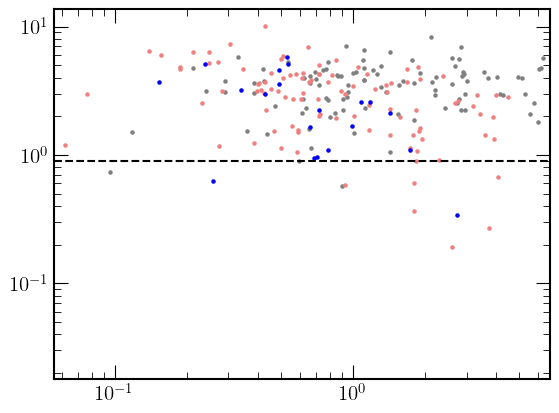

No mergers have occured
finished until t = 0.0 0.2326962947845459
finished until t = 0.5 2.5818021297454834
finished until t = 1.0 7.090541839599609
finished until t = 1.5 13.803914308547974
finished until t = 2.0 22.717774629592896
finished until t = 2.5 33.906028270721436
finished until t = 3.0 47.491713762283325
finished until t = 3.5 63.63043785095215
finished until t = 4.0 82.42157864570618
finished until t = 4.5 103.95902371406555
finished until t = 5.0 128.46859431266785
finished until t = 5.5 156.22648859024048
finished until t = 6.0 187.2895634174347
finished until t = 6.5 221.5921106338501
finished until t = 7.0 258.8334090709686
finished until t = 7.5 299.1076488494873
finished until t = 8.0 342.53695273399353
finished until t = 8.5 389.02557921409607
finished until t = 9.0 438.40659642219543
finished until t = 9.5 490.6230833530426
finished until t = 10.0 545.5436556339264


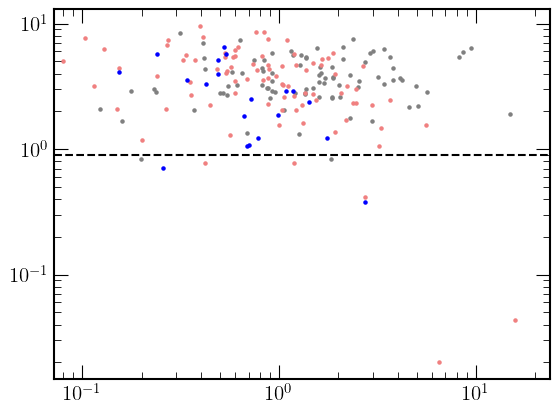

A merger has occured
finished until t = 0.0 0.20428061485290527
finished until t = 0.5 2.138741970062256
finished until t = 1.0 5.810973405838013
finished until t = 1.5 11.211618661880493
finished until t = 2.0 18.35549283027649
finished until t = 2.5 27.248415231704712
finished until t = 3.0 37.87666893005371
finished until t = 3.5 50.31059241294861
finished until t = 4.0 64.4856824874878
finished until t = 4.5 80.47470378875732
finished until t = 5.0 98.29366540908813
finished until t = 5.5 118.18122911453247
finished until t = 6.0 140.25125312805176
finished until t = 6.5 164.6948733329773
finished until t = 7.0 191.5737018585205
finished until t = 7.5 221.0204725265503
finished until t = 8.0 253.0124967098236
finished until t = 8.5 287.63165831565857
finished until t = 9.0 324.6937212944031
finished until t = 9.5 364.13463020324707
finished until t = 10.0 405.84349513053894


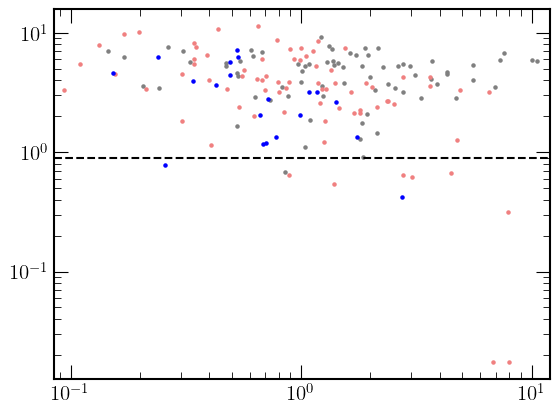

No mergers have occured
finished until t = 0.0 0.18732237815856934
finished until t = 0.5 1.8559587001800537
finished until t = 1.0 5.034635305404663
finished until t = 1.5 9.711554050445557
finished until t = 2.0 15.926884651184082
finished until t = 2.5 23.650754928588867
finished until t = 3.0 32.93108129501343
finished until t = 3.5 43.766751289367676
finished until t = 4.0 56.221985816955566
finished until t = 4.5 70.37902545928955
finished until t = 5.0 86.23635482788086
finished until t = 5.5 103.87057662010193
finished until t = 6.0 123.227215051651
finished until t = 6.5 144.32610321044922
finished until t = 7.0 167.2036395072937
finished until t = 7.5 191.87015986442566
finished until t = 8.0 218.32396793365479
finished until t = 8.5 246.5352075099945
finished until t = 9.0 276.5276322364807
finished until t = 9.5 308.3341703414917
finished until t = 10.0 341.9505512714386


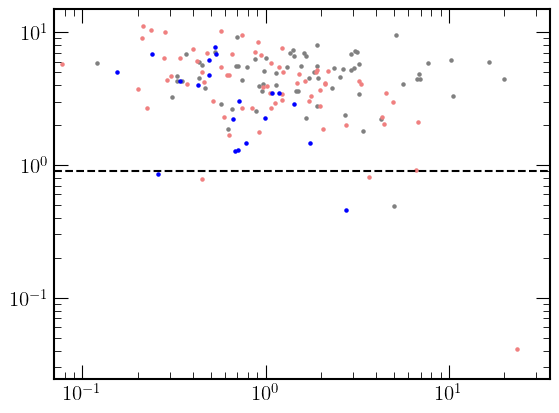

A merger has occured
finished until t = 0.0 0.21293044090270996
finished until t = 0.5 2.239837169647217
finished until t = 1.0 6.102196455001831
finished until t = 1.5 11.849304676055908
finished until t = 2.0 19.51241183280945
finished until t = 2.5 29.054267168045044
finished until t = 3.0 40.45656752586365
finished until t = 3.5 53.77260208129883
finished until t = 4.0 68.98393893241882
finished until t = 4.5 86.12551045417786
finished until t = 5.0 105.16752743721008
finished until t = 5.5 126.15648460388184
finished until t = 6.0 149.1013035774231
finished until t = 6.5 174.00658655166626
finished until t = 7.0 200.9107882976532
finished until t = 7.5 229.88042378425598
finished until t = 8.0 260.89043855667114
finished until t = 8.5 294.0910065174103
finished until t = 9.0 329.65194511413574
finished until t = 9.5 367.82368063926697
finished until t = 10.0 408.790566444397


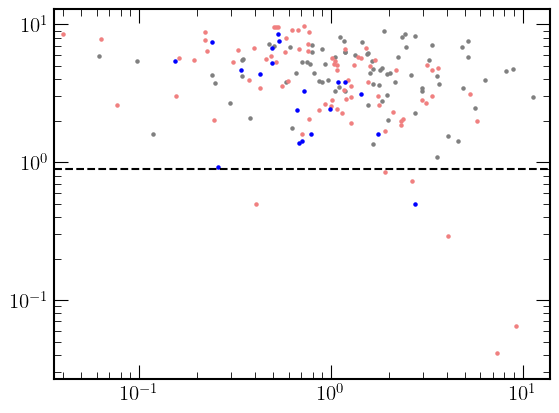

No mergers have occured
finished until t = 0.0 0.2257096767425537
finished until t = 0.5 2.376046895980835
finished until t = 1.0 6.436374187469482
finished until t = 1.5 12.408380270004272
finished until t = 2.0 20.30501675605774
finished until t = 2.5 30.14320969581604
finished until t = 3.0 41.92380380630493
finished until t = 3.5 55.575804471969604
finished until t = 4.0 71.15564036369324
finished until t = 4.5 88.59073090553284
finished until t = 5.0 107.97638154029846
finished until t = 5.5 129.29790043830872
finished until t = 6.0 152.6409878730774
finished until t = 6.5 178.04843187332153
finished until t = 7.0 205.70092391967773
finished until t = 7.5 235.54612946510315
finished until t = 8.0 267.7440915107727
finished until t = 8.5 302.2277262210846
finished until t = 9.0 339.078768491745
finished until t = 9.5 378.2471270561218
finished until t = 10.0 419.8328821659088


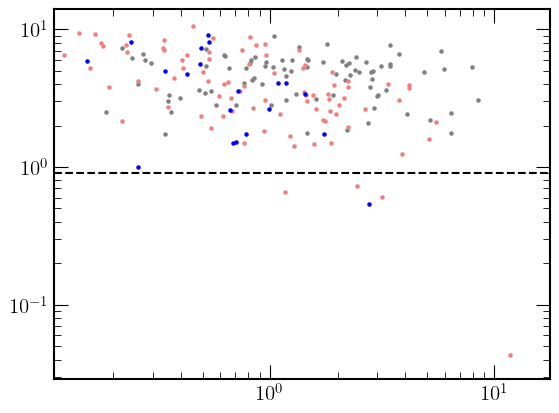

No mergers have occured
finished until t = 0.0 0.19554567337036133
finished until t = 0.5 2.1806154251098633
finished until t = 1.0 6.063638210296631
finished until t = 1.5 12.019552946090698
finished until t = 2.0 19.979570388793945
finished until t = 2.5 30.070011377334595
finished until t = 3.0 42.388601779937744
finished until t = 3.5 56.95241713523865
finished until t = 4.0 73.78477048873901
finished until t = 4.5 92.88692045211792
finished until t = 5.0 114.22167444229126
finished until t = 5.5 137.65835690498352
finished until t = 6.0 163.17598152160645
finished until t = 6.5 190.72738456726074
finished until t = 7.0 220.33781623840332
finished until t = 7.5 252.04834151268005
finished until t = 8.0 285.7317204475403
finished until t = 8.5 321.40623903274536
finished until t = 9.0 359.01889204978943
finished until t = 9.5 398.6507158279419
finished until t = 10.0 440.2977342605591


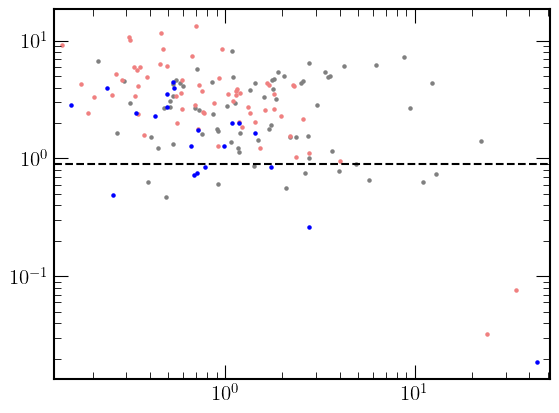

A merger has occured
finished until t = 0.0 0.4374701976776123
finished until t = 0.5 2.471980571746826
finished until t = 1.0 6.353732109069824
finished until t = 1.5 12.07157826423645
finished until t = 2.0 19.613457202911377
finished until t = 2.5 29.00043272972107
finished until t = 3.0 40.32037329673767
finished until t = 3.5 53.59052300453186
finished until t = 4.0 68.96766686439514
finished until t = 4.5 86.68259787559509
finished until t = 5.0 106.8655014038086
finished until t = 5.5 129.44393515586853


/home/vk9342/.local/lib/python3.8/site-packages/rebound/simulation.py:1032: RuntimeWarning: At least 10 predictor corrector loops in IAS15 did not converge. This is typically an indication of the timestep being too large.
  warnings.warn(msg[1:], RuntimeWarning)


finished until t = 6.0 154.372088432312
finished until t = 6.5 181.4669713973999
finished until t = 7.0 210.7009220123291
finished until t = 7.5 242.17986536026
finished until t = 8.0 275.92751455307007
finished until t = 8.5 312.1300003528595
finished until t = 9.0 350.5107741355896
finished until t = 9.5 391.142480134964
finished until t = 10.0 434.0186822414398


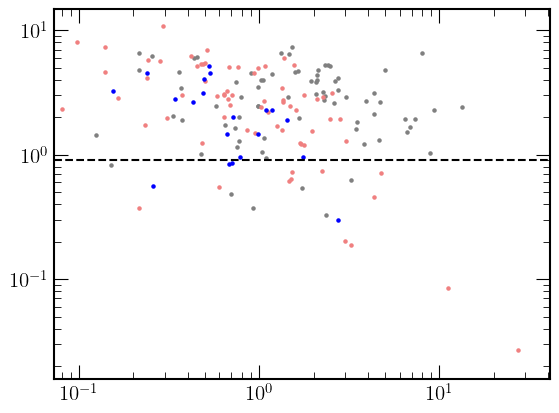

A merger has occured
finished until t = 0.0 0.22237300872802734
finished until t = 0.5 2.603381633758545
finished until t = 1.0 7.236649036407471
finished until t = 1.5 14.245260238647461
finished until t = 2.0 23.812310457229614
finished until t = 2.5 35.807546854019165
finished until t = 3.0 50.27878546714783
finished until t = 3.5 67.15495586395264
finished until t = 4.0 86.57545590400696
finished until t = 4.5 108.46332144737244
finished until t = 5.0 132.87949347496033
finished until t = 5.5 159.68820595741272
finished until t = 6.0 188.84542560577393
finished until t = 6.5 220.30124425888062
finished until t = 7.0 254.15042901039124
finished until t = 7.5 290.60384726524353
finished until t = 8.0 329.69206857681274
finished until t = 8.5 371.5457720756531
finished until t = 9.0 416.13410329818726
finished until t = 9.5 463.3850235939026
finished until t = 10.0 513.2985911369324


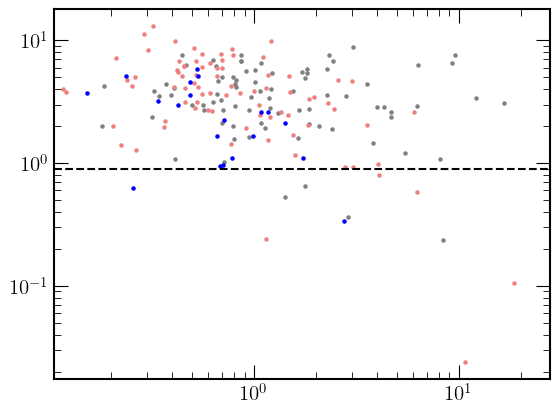

A merger has occured
finished until t = 0.0 0.19426321983337402
finished until t = 0.5 2.0414278507232666
finished until t = 1.0 5.5712571144104
finished until t = 1.5 10.785099029541016
finished until t = 2.0 17.67237615585327
finished until t = 2.5 26.2733314037323
finished until t = 3.0 36.55665302276611
finished until t = 3.5 48.55761742591858
finished until t = 4.0 62.328582763671875
finished until t = 4.5 77.86950922012329
finished until t = 5.0 95.2947473526001
finished until t = 5.5 114.87237167358398
finished until t = 6.0 136.73731207847595
finished until t = 6.5 161.0127968788147
finished until t = 7.0 187.65913724899292
finished until t = 7.5 216.64393496513367
finished until t = 8.0 247.89470052719116
finished until t = 8.5 281.432656288147
finished until t = 9.0 317.27536702156067
finished until t = 9.5 355.29904413223267
finished until t = 10.0 395.64730191230774


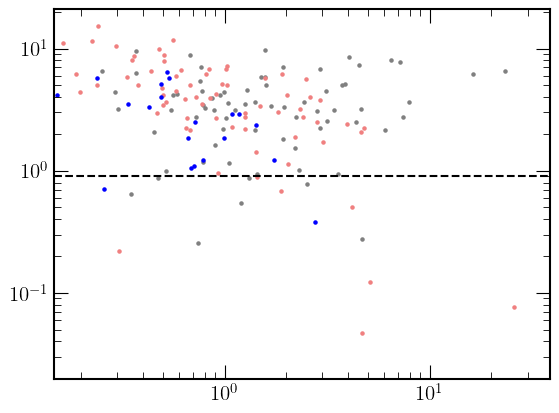

A merger has occured
finished until t = 0.0 0.23042988777160645
finished until t = 0.5 2.650639772415161
finished until t = 1.0 7.394158124923706
finished until t = 1.5 14.675004720687866
finished until t = 2.0 24.7529513835907
finished until t = 2.5 37.65650391578674
finished until t = 3.0 53.33114528656006
finished until t = 3.5 71.81441164016724
finished until t = 4.0 92.99861812591553
finished until t = 4.5 116.90731287002563
finished until t = 5.0 143.55432534217834
finished until t = 5.5 172.93945240974426
finished until t = 6.0 205.02337169647217
finished until t = 6.5 239.7209973335266
finished until t = 7.0 276.9165141582489
finished until t = 7.5 316.62915301322937
finished until t = 8.0 358.91006684303284
finished until t = 8.5 403.79107689857483
finished until t = 9.0 451.22197127342224
finished until t = 9.5 501.17668175697327
finished until t = 10.0 553.5815055370331


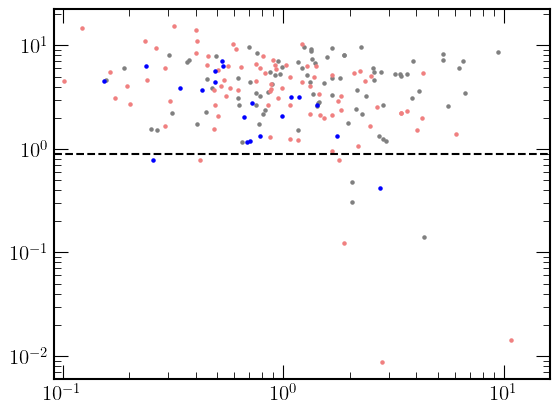

No mergers have occured
finished until t = 0.0 0.20390748977661133
finished until t = 0.5 2.210911512374878
finished until t = 1.0 6.029189109802246
finished until t = 1.5 11.704726934432983
finished until t = 2.0 19.267399311065674
finished until t = 2.5 28.779529094696045
finished until t = 3.0 40.39122223854065
finished until t = 3.5 54.13218688964844
finished until t = 4.0 70.04884433746338
finished until t = 4.5 88.10721611976624
finished until t = 5.0 108.30117416381836
finished until t = 5.5 130.60910534858704
finished until t = 6.0 155.07976627349854
finished until t = 6.5 181.7112193107605
finished until t = 7.0 210.55773496627808
finished until t = 7.5 241.62665820121765
finished until t = 8.0 275.0325708389282
finished until t = 8.5 310.6538689136505
finished until t = 9.0 348.75140047073364
finished until t = 9.5 389.30049753189087
finished until t = 10.0 432.3748676776886


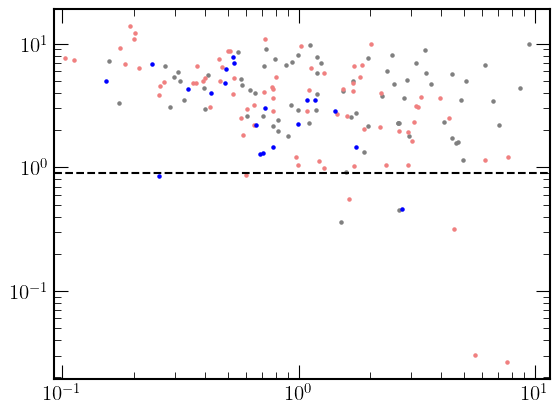

No mergers have occured
finished until t = 0.0 0.17630863189697266
finished until t = 0.5 1.8138506412506104
finished until t = 1.0 4.942387104034424
finished until t = 1.5 9.547435522079468
finished until t = 2.0 15.62721586227417
finished until t = 2.5 23.245913982391357
finished until t = 3.0 32.34828758239746
finished until t = 3.5 42.9565749168396
finished until t = 4.0 55.114431619644165
finished until t = 4.5 68.76808047294617
finished until t = 5.0 83.9522635936737
finished until t = 5.5 100.75315165519714
finished until t = 6.0 119.2563488483429
finished until t = 6.5 139.8695878982544
finished until t = 7.0 162.58619904518127
finished until t = 7.5 187.32128977775574
finished until t = 8.0 214.2544629573822
finished until t = 8.5 243.22666382789612
finished until t = 9.0 274.1893398761749
finished until t = 9.5 307.05820965766907
finished until t = 10.0 341.83803486824036


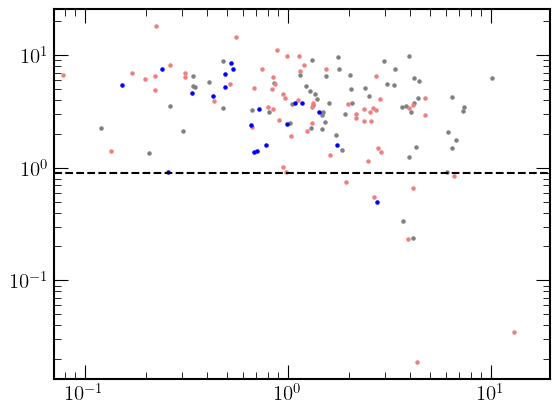

No mergers have occured
finished until t = 0.0 0.20528745651245117
finished until t = 0.5 2.2587389945983887
finished until t = 1.0 6.198225498199463
finished until t = 1.5 12.050096988677979
finished until t = 2.0 19.887518882751465
finished until t = 2.5 29.9026517868042
finished until t = 3.0 41.99174880981445
finished until t = 3.5 56.296464920043945
finished until t = 4.0 72.80464696884155
finished until t = 4.5 91.47378635406494
finished until t = 5.0 112.29469227790833
finished until t = 5.5 135.22865104675293
finished until t = 6.0 160.26118159294128
finished until t = 6.5 187.5053060054779
finished until t = 7.0 216.90289664268494
finished until t = 7.5 248.61032390594482
finished until t = 8.0 282.76194047927856
finished until t = 8.5 319.283145904541
finished until t = 9.0 358.2986307144165
finished until t = 9.5 399.8453543186188
finished until t = 10.0 443.8885118961334


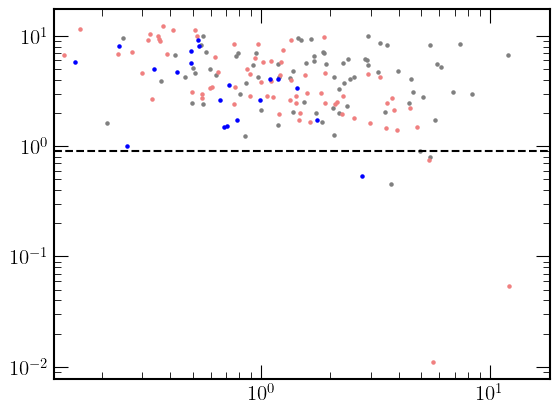

A merger has occured
finished until t = 0.0 0.2010023593902588
finished until t = 0.5 2.2823479175567627
finished until t = 1.0 6.369975566864014
finished until t = 1.5 12.434443712234497
finished until t = 2.0 20.490665912628174
finished until t = 2.5 30.438366889953613
finished until t = 3.0 42.289371490478516
finished until t = 3.5 56.08707404136658
finished until t = 4.0 71.78213882446289
finished until t = 4.5 89.44425988197327
finished until t = 5.0 109.09133672714233
finished until t = 5.5 131.00232863426208
finished until t = 6.0 155.20743775367737
finished until t = 6.5 181.545734167099


In [ ]:
no_merger_Re = []
no_merger_n = []
merger_Re = []
merger_n = []
num_mergers = []
max_masses =[]
max_masses_m =[]
max_masses_nom =[]

for i in range(len(n_values)):
    n = n_values[i]
    for j in range (len(R_e_values)):
        R_e = R_e_values[j]
        UGC7369_R_e = R_e
        # projected separation divided by effective radius from Georgiev
        UGC7369_rperps_norms =  np.array([2.23066667, 1.428     , 0.99866667, 1.96933333, 1.97866667,
               0.63466667, 0.13066667, 0.00933333, 0.24266667, 0.364     ,
               1.372     , 0.42      , 0.644     , 0.37333333, 0.42      ,
               0.82133333, 0.99866667, 1.77333333, 0.868     , 1.148     ,
               1.22266667])
        # physical projected radii
        UGC7369_rperps = UGC7369_rperps_norms*UGC7369_R_e
        
        run_iterations(10, 'NFW-1', phi_NFW, clib_additional_forces.NFW_DF_Petts, [11.82, 19.54], NFW_f_interp)
        data_initial = np.genfromtxt('Sim_5_NFW-1_0_'+str(R_e)+'_'+str(n)+'.txt', skip_header=2)
        initial_masses = data_initial[:, 1]
        initial_radii = np.sqrt(data_initial[:, 2]**2 + data_initial[:, 3]**2 + data_initial[:, 4]**2)
        data_final = np.genfromtxt('Sim_5_NFW-1_20_'+str(R_e)+'_'+str(n)+'.txt', skip_header=2)
        final_masses = data_final[:, 1]
        final_radii = np.sqrt(data_final[:, 2]**2 + data_final[:, 3]**2 + data_final[:, 4]**2)
        
        parent_directory = '/home/vk9342/USRP2023'
        outputtime=0
        destination_directory = os.path.join(parent_directory, f'Sim_5_{R_e}_{n}')
        os.makedirs(destination_directory, exist_ok=True)
        while outputtime<21:
            #source_file = output_name + '_' + str(output_time) + '_' + str(R_e) + '_' + str(n) + '.txt'
            source_file = 'Sim_5_NFW-1' + '_' + str(outputtime) + '_' + str(R_e) + '_' + str(n) + '.txt'
            shutil.copy(source_file, destination_directory)
            outputtime = outputtime+1
        

        plt.plot([1e-2, 1e2], [0.9, 0.9], 'k--')
        plt.scatter(initial_masses, initial_radii, color='gray', s=5)
        plt.scatter(final_masses, final_radii, color='lightcoral', s=5)
        plt.scatter(UGC7369_masses, UGC7369_rperps, color='b', s=5)
        plt.yscale('log')
        plt.xscale('log')
        plt.xlim(min(final_masses)*0.9, max(final_masses)*1.5)
        plt.show()
        
        if len(initial_masses)- len(final_masses) == 0:
            print ('No mergers have occured')
            no_merger_Re.append(R_e)
            no_merger_n.append (n)
            max_masses_nom.append(max(final_masses))
        else:
            print ('A merger has occured')
            merger_Re.append(R_e)
            merger_n.append(n)
            num_mergers.append(len(initial_masses)- len(final_masses))
            max_masses_m.append(max(final_masses))
            
        max_masses.append(max(final_masses))
            
            
plt.scatter (no_merger_Re, no_merger_n, color = 'blue', s=5)
plt.scatter (merger_Re, merger_n, color = 'red', s=5)
plt.xlabel('Re (kpc)')
plt.ylabel('n')
plt.show()
  
cmap = 'plasma'  
plt.scatter (no_merger_Re, no_merger_n, color = 'deepskyblue', s=5)
plt.scatter (merger_Re, merger_n, cmap=cmap, c=num_mergers, s=5)
plt.xlabel('Re (kpc)')
plt.ylabel('n')
plt.colorbar()
plt.show()     